# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

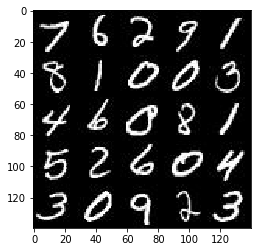

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

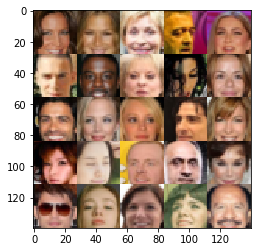

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                 name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_rate= tf.placeholder(tf.float32, name='learn_rate')

    return (inputs_real, inputs_z, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        lrelu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # Output is 14x14x64
        x2 = tf.layers.conv2d(lrelu1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2) # leaky relu
        # Output is 7x7x128
        x3 = tf.layers.conv2d(lrelu1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3) # leaky relu
        # Output is 4x4x256
        flat = tf.reshape(lrelu3, (-1, 4*4*256))
        dropout = tf.nn.dropout(flat, keep_prob=0.7)
        logits = tf.layers.dense(dropout, 1)
        output = tf.sigmoid(logits)

    return (output, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [21]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        # Output is 7x7x512
        x2 = tf.layers.conv2d_transpose(lrelu1, 256, 5, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # Output is 7x7x256
        x3 = tf.layers.conv2d_transpose(lrelu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # Ouput is 14x14x128
        x4 = tf.layers.conv2d_transpose(lrelu3, 128, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        # Output is 28x28x64
        dropout = tf.nn.dropout(lrelu4, keep_prob=0.5)
        logits = tf.layers.conv2d_transpose(dropout, out_channel_dim, 5, strides=1, padding='same')
        # Output is 28x28x out_channel_dim
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [22]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Functions
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * 0.9)) 
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))  
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    
    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [23]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, 
                                                                                  var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, 
                                                                                  var_list=g_vars)
    
    return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [24]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [25]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(image_width=data_shape[1],
                                             image_height=data_shape[2],
                                             image_channels= data_shape[3],
                                             z_dim=z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    is_train = tf.placeholder(tf.bool)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z,
                                               is_train:True})
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, 
                                              is_train:False})
                
                if steps % 25 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z, inputs_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % 100 == 0:  
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.5360... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.4953... Generator Loss: 0.7243
Epoch 1/2... Discriminator Loss: 1.4813... Generator Loss: 0.7726


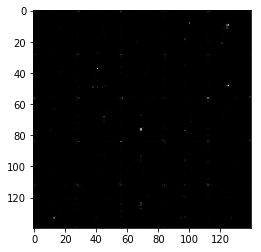

Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.8055
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.7844
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.7614


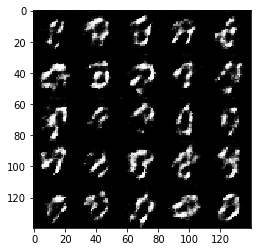

Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 0.7348
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.4877... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3752... Generator Loss: 0.8012


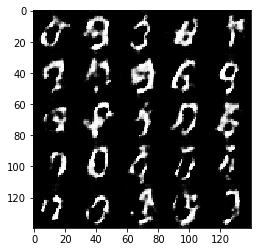

Epoch 1/2... Discriminator Loss: 1.4447... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 1.4334... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.4540... Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.4429... Generator Loss: 0.7824


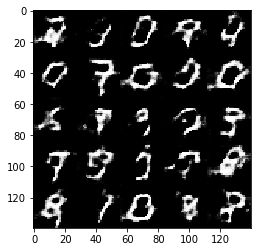

Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.7643
Epoch 1/2... Discriminator Loss: 1.4188... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.4403... Generator Loss: 0.7650


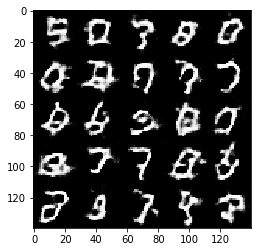

Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.7732
Epoch 1/2... Discriminator Loss: 1.3898... Generator Loss: 0.7904


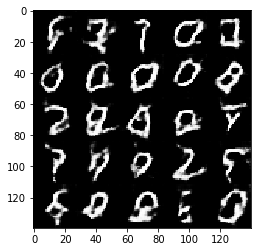

Epoch 1/2... Discriminator Loss: 1.4016... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.3966... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.7738
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.7778


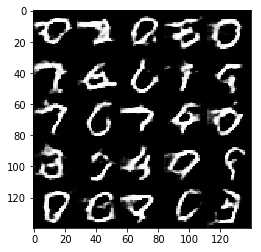

Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.7958
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.8004


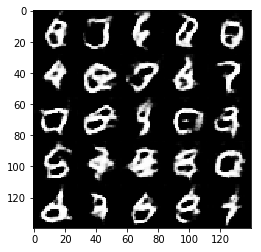

Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.8018
Epoch 1/2... Discriminator Loss: 1.4256... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.4166... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 0.7824


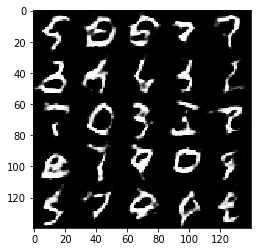

Epoch 1/2... Discriminator Loss: 1.4134... Generator Loss: 0.7713
Epoch 2/2... Discriminator Loss: 1.4481... Generator Loss: 0.7606
Epoch 2/2... Discriminator Loss: 1.4118... Generator Loss: 0.7733
Epoch 2/2... Discriminator Loss: 1.4155... Generator Loss: 0.7970


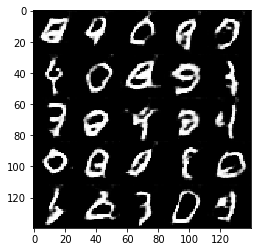

Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7530
Epoch 2/2... Discriminator Loss: 1.3728... Generator Loss: 0.8222
Epoch 2/2... Discriminator Loss: 1.4109... Generator Loss: 0.8144
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.8051


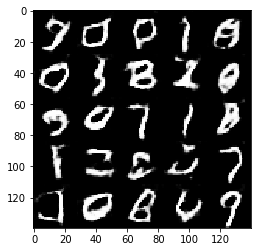

Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 1.3860... Generator Loss: 0.8286
Epoch 2/2... Discriminator Loss: 1.4212... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.4043... Generator Loss: 0.7542


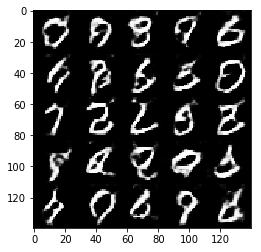

Epoch 2/2... Discriminator Loss: 1.3827... Generator Loss: 0.8016
Epoch 2/2... Discriminator Loss: 1.4000... Generator Loss: 0.7965
Epoch 2/2... Discriminator Loss: 1.3649... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.7819


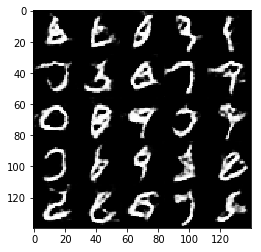

Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.8048
Epoch 2/2... Discriminator Loss: 1.4004... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.7674
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.7885


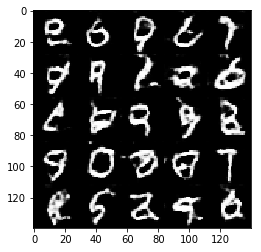

Epoch 2/2... Discriminator Loss: 1.3820... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.3609... Generator Loss: 0.7899
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 0.8507
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.7813


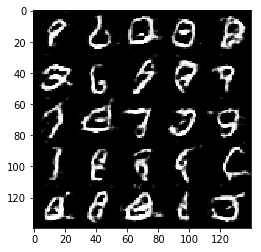

Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.7865
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.3633... Generator Loss: 0.7715
Epoch 2/2... Discriminator Loss: 1.3737... Generator Loss: 0.7902


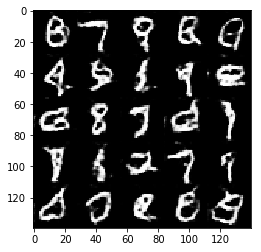

Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 0.7934
Epoch 2/2... Discriminator Loss: 1.3663... Generator Loss: 0.8110
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.7390
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.8598


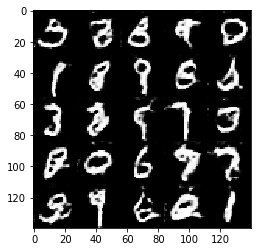

Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.3578... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.3533... Generator Loss: 0.7812
Epoch 2/2... Discriminator Loss: 1.3805... Generator Loss: 0.8123


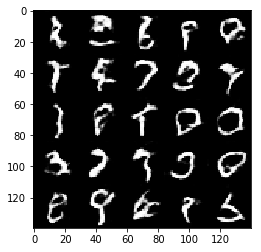

Epoch 2/2... Discriminator Loss: 1.3824... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.3395... Generator Loss: 0.7990


In [26]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.8742
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.3439
Epoch 1/1... Discriminator Loss: 0.6651... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.5795... Generator Loss: 2.0797


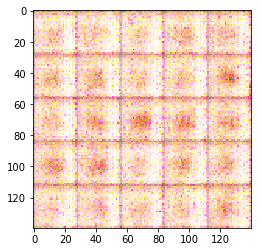

Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.1958
Epoch 1/1... Discriminator Loss: 0.8856... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.4398
Epoch 1/1... Discriminator Loss: 0.9716... Generator Loss: 1.2403


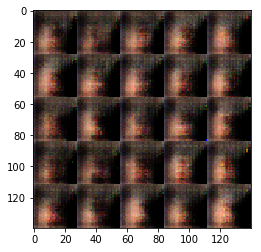

Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.9013
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8605


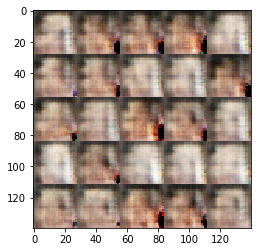

Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.9873


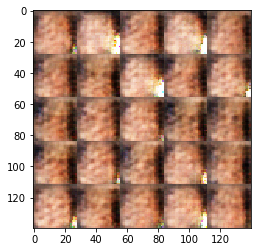

Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.9100
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.7581


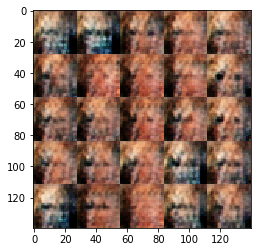

Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8544


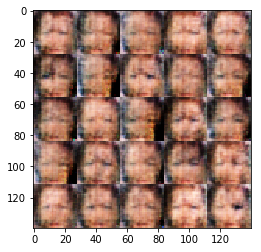

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.6879


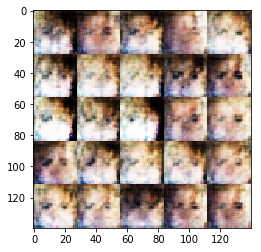

Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.9502
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7982


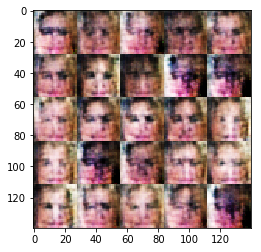

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.7892


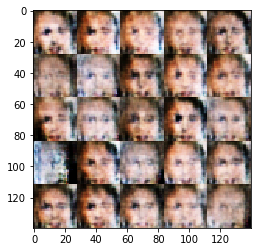

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.7988


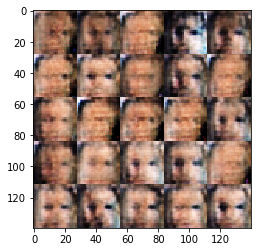

Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 0.7353
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.9976
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.7437


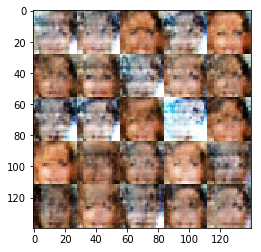

Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.8334


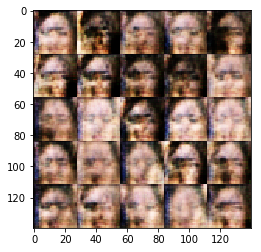

Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.8227


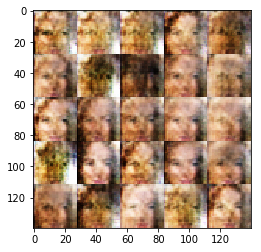

Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8578
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7571


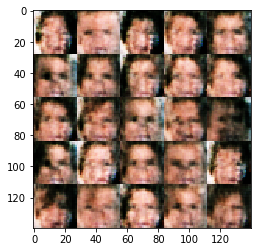

Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.7556


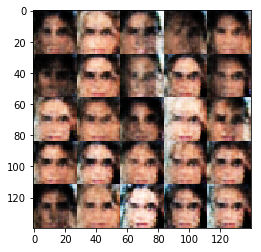

Epoch 1/1... Discriminator Loss: 1.3581... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.7709


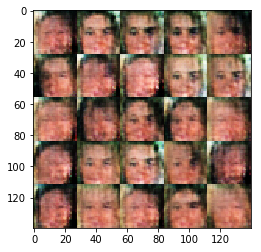

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.7854


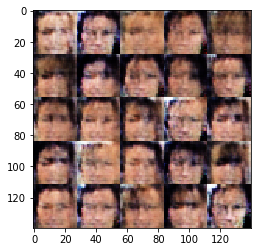

Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7593


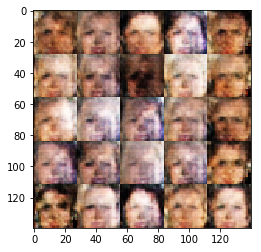

Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.7464


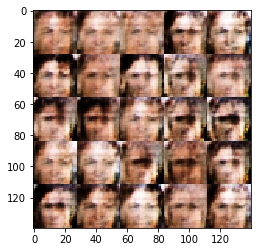

Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7686


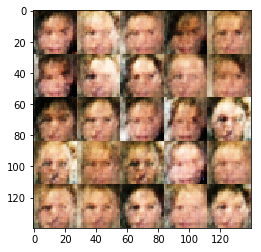

Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7806
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8020


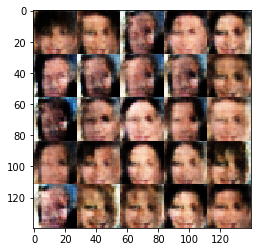

Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7804


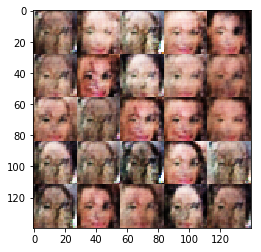

Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7636


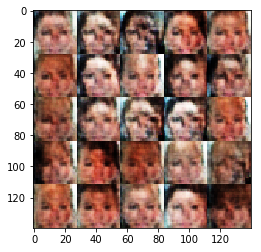

Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8176


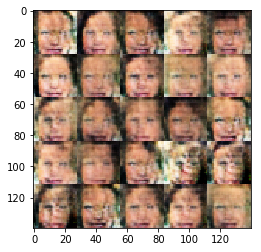

Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.8320


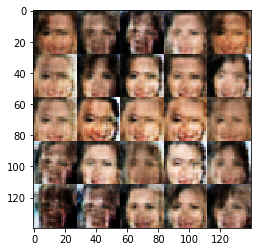

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.8072


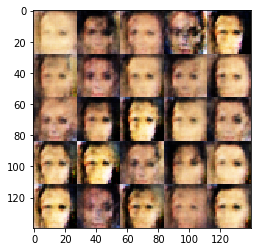

Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.7677


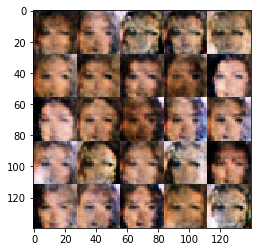

Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.7470


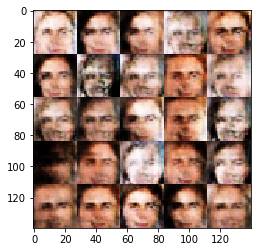

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7670


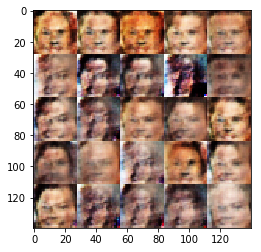

Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.8144


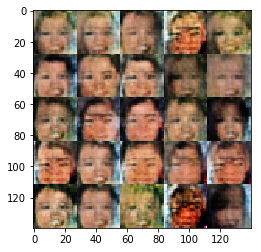

Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.8103
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.8180


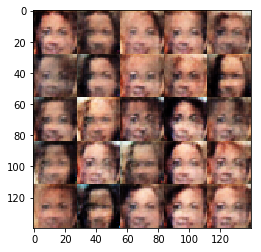

Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.8006
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7943


In [27]:
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.